In [1]:
import os
import pdb
import time
import random
import logging
from os.path import join
import mxnet as mx
from mxnet import gluon, nd, autograd
from mxnet.gluon import nn, utils
import matplotlib.pyplot as plt
import numpy as np


### Step 0: Setup: Path and Parameters

In [10]:
PathDataset = 'lfw_dataset'
ctx = mx.gpu()
lr = 0.002
batch_size = 64
num_epochs = 2000
target_size = 64
beta1=0.5

### Step 1: Dataset Preparation

* 首先将图像resize至64x64，再把像素值归一化到[-1, 1]之间

In [3]:
def transform(data, target_size):
    data = mx.image.imresize(data, target_size, target_size)
    # normalize to [-1, 1]
    data = data.transpose((2, 0, 1)).astype('float32')/127.5 - 1
    # 注意这里：如果输入不是三通道，则复制到三个通道
    if data.shape[0] == 1:
        data = nd.tile(data, (3, 1, 1))
    return nd.expand_dims(data, 0)

In [4]:
img_list = []
for dirpath, dirs, files in os.walk(PathDataset):
    for file in files:
        if not file.endswith('.jpg'):
            continue
        img = mx.image.imread(join(dirpath, file))
        img = transform(img, target_size)
        img_list.append(img)


#### 注意:  
使用nd.concatenate(list)直接把多个ndarray形式的数组合并到一起

In [5]:
train_iter = mx.io.NDArrayIter(data=nd.concatenate(img_list),batch_size=batch_size)

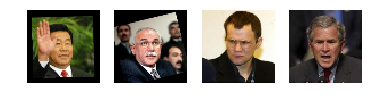

In [6]:
def visualize(img_arr):
    plt.imshow(((img_arr.asnumpy().transpose(1, 2, 0) + 1.0) * 127.5).astype(np.uint8))
    plt.axis('off')
for i in range(4):
    plt.subplot(1, 4, i+1)
    visualize(random.choice(img_list)[0])
plt.show()

### Step 2: Define Network

DCGAN的架构：  
判别器：使用标准CNN架构  
生成器：使用upconvolution代替convolution，使得输出特征图逐渐变大  
* 弃用Pooling：判别器改为strided convolution，生成器改成反卷积
* G和D中都使用BatchNorm
* 去除FC layer
* 生成器除最后一层使用ReLU，最后一层使用Tanh 判别器所有层使用LeakyRelu

In [7]:
class Latent_layer(nn.HybridBlock):
    def __init__(self, **kwags):
        super(Latent_layer, self).__init__(**kwags)
    def hybrid_forward(self, F, x):
        return F.reshape(data=x, shape=(x.shape[0], x.shape[1], 1, 1))

In [9]:
#check custom layer
tnet = nn.HybridSequential()
tnet.add(Latent_layer())


In [8]:
nc = 3
ngf = 64
G_net = nn.Sequential()
with G_net.name_scope():
    # 输入为z，送入第一个转置卷积
    G_net.add(Latent_layer())
    G_net.add(nn.Conv2DTranspose(ngf * 8, 4, 1, 0, use_bias=False ))
    G_net.add(nn.BatchNorm())
    G_net.add(nn.Activation('relu'))
    # (ngf*8 x 4 x 4)
    G_net.add(nn.Conv2DTranspose(ngf * 4, 4, 2, 1, use_bias=False))
    G_net.add(nn.BatchNorm())
    G_net.add(nn.Activation('relu'))
    # (ngf*4 x 8 x 8)
    G_net.add(nn.Conv2DTranspose(ngf * 2, 4, 2, 1, use_bias=False ))
    G_net.add(nn.BatchNorm())
    G_net.add(nn.Activation('relu'))
    # (ngf*2 16 x 16)
    G_net.add(nn.Conv2DTranspose(ngf, 4, 2, 1, use_bias=False ))
    G_net.add(nn.BatchNorm())
    G_net.add(nn.Activation('relu'))
    # (ngf*2 32 x 32)
    G_net.add(nn.Conv2DTranspose(nc, 4, 2, 1, use_bias=False ))
    G_net.add(nn.BatchNorm())
    G_net.add(nn.Activation('tanh'))
    # (nc x 64 x 64)
    
# ============ Build D net ============
ndf = 64
D_net = nn.Sequential()
with D_net.name_scope():
    # (nc x 64 x 64)
    D_net.add(nn.Conv2D(ndf, 4, 2, 1, use_bias=False))
    D_net.add(nn.BatchNorm())
    D_net.add(nn.LeakyReLU(0.2))
    # (ndf x 32 x 32)
    D_net.add(nn.Conv2D(2*ndf, 4, 2, 1, use_bias=False))
    D_net.add(nn.BatchNorm())
    D_net.add(nn.LeakyReLU(0.2))
    # (2*ndf x 16 x 16)
    D_net.add(nn.Conv2D(4*ndf, 4, 2, 1, use_bias=False))
    D_net.add(nn.BatchNorm())
    D_net.add(nn.LeakyReLU(0.2))
    # (4*ndf x 8 x 8)
    D_net.add(nn.Conv2D(8*ndf, 4, 2, 1, use_bias=False))
    D_net.add(nn.BatchNorm())
    D_net.add(nn.LeakyReLU(0.2))
    # (8*ndf x 4 x 4)
    D_net.add(nn.Conv2D(1, 4, 1, 0, use_bias=False))

### Step 3: Training Config

In [9]:
loss = gluon.loss.SigmoidBinaryCrossEntropyLoss()
G_net.initialize(mx.init.Normal(0.02), ctx=ctx)
D_net.initialize(mx.init.Normal(0.02), ctx=ctx)
trainer_G = gluon.Trainer(
    G_net.collect_params(),'adam',
    {'learning_rate': 4*lr, 'beta1':beta1})
trainer_D = gluon.Trainer(
    D_net.collect_params(),'adam',
    {'learning_rate': lr, 'beta1':beta1})

### Step 4: Training Loop

<IPython.core.display.Javascript object>


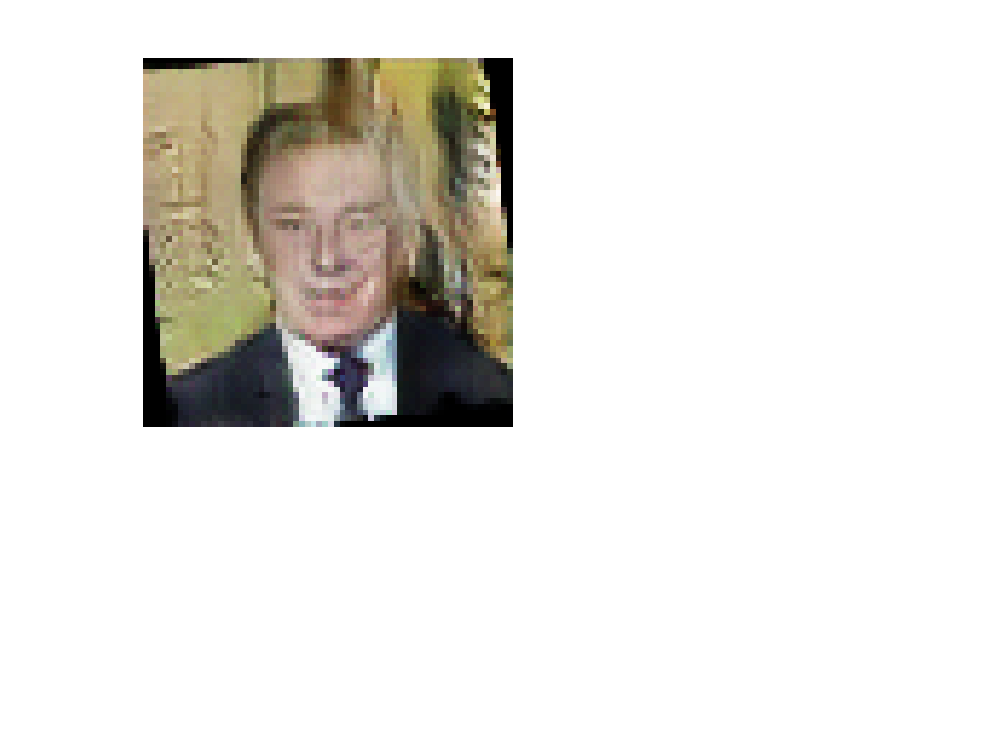

INFO:root:Epoch: 0, Iter: 0, speed: 157.62893506475203 samples/s, D_loss: 1.6363146305084229, G_loss: 43.94219207763672, train_acc: 0.5546875
INFO:root:Epoch: 0, Iter: 50, speed: 1636.9812296471564 samples/s, D_loss: 0.20541757345199585, G_loss: 9.330238342285156, train_acc: 0.8821997549019608
INFO:root:Epoch: 0, Iter: 100, speed: 1743.3703912972885 samples/s, D_loss: 1.7308541536331177, G_loss: 2.0441393852233887, train_acc: 0.8066212871287128
INFO:root:Epoch: 0, Iter: 150, speed: 1777.6358446959412 samples/s, D_loss: 1.0317977666854858, G_loss: 1.2960779666900635, train_acc: 0.7826986754966887
INFO:root:Epoch: 0, Iter: 200, speed: 1683.2553018046829 samples/s, D_loss: 1.2355597019195557, G_loss: 3.532045841217041, train_acc: 0.7457633706467661
INFO:root:[+]Epoch: facc = 0.7427536231884058
INFO:root:Epoch: 1, Iter: 0, speed: 2766.0355910022977 samples/s, D_loss: 0.971549928188324, G_loss: 3.268355131149292, train_acc: 0.796875
INFO:root:Epoch: 1, Iter: 50, speed: 1757.3515941080198 sa

INFO:root:Epoch: 10, Iter: 100, speed: 1747.7859700753975 samples/s, D_loss: 0.9461404085159302, G_loss: 3.582442283630371, train_acc: 0.7186726485148515
INFO:root:Epoch: 10, Iter: 150, speed: 1740.6346641420855 samples/s, D_loss: 1.1068352460861206, G_loss: 1.7432054281234741, train_acc: 0.7131622516556292
INFO:root:Epoch: 10, Iter: 200, speed: 1616.7693938517875 samples/s, D_loss: 0.8334581255912781, G_loss: 3.3359146118164062, train_acc: 0.7163790422885572
INFO:root:[+]Epoch: facc = 0.7158439009661836
INFO:root:Epoch: 11, Iter: 0, speed: 2893.8708063820613 samples/s, D_loss: 1.090851068496704, G_loss: 2.6053924560546875, train_acc: 0.640625
INFO:root:Epoch: 11, Iter: 50, speed: 1646.974642149374 samples/s, D_loss: 0.7947126626968384, G_loss: 2.0755867958068848, train_acc: 0.6721813725490197
INFO:root:Epoch: 11, Iter: 100, speed: 1725.873469807633 samples/s, D_loss: 1.1466645002365112, G_loss: 1.770936369895935, train_acc: 0.6799195544554455
INFO:root:Epoch: 11, Iter: 150, speed: 168

INFO:root:Epoch: 20, Iter: 150, speed: 1617.5000512180866 samples/s, D_loss: 0.8197492957115173, G_loss: 2.333221673965454, train_acc: 0.7433774834437086
INFO:root:Epoch: 20, Iter: 200, speed: 1654.0174622442125 samples/s, D_loss: 0.8798753619194031, G_loss: 3.3499956130981445, train_acc: 0.7425761815920398
INFO:root:[+]Epoch: facc = 0.743546195652174
INFO:root:Epoch: 21, Iter: 0, speed: 2936.2238410885784 samples/s, D_loss: 0.5531091094017029, G_loss: 2.5569581985473633, train_acc: 0.8203125
INFO:root:Epoch: 21, Iter: 50, speed: 1808.559582280613 samples/s, D_loss: 1.0782573223114014, G_loss: 4.142952919006348, train_acc: 0.7472426470588235
INFO:root:Epoch: 21, Iter: 100, speed: 1668.7209364490282 samples/s, D_loss: 0.9598851799964905, G_loss: 1.7487256526947021, train_acc: 0.7466738861386139
INFO:root:Epoch: 21, Iter: 150, speed: 1727.8286302780639 samples/s, D_loss: 0.987933337688446, G_loss: 3.399272918701172, train_acc: 0.7476717715231788
INFO:root:Epoch: 21, Iter: 200, speed: 163

INFO:root:[+]Epoch: facc = 0.8295969202898551
INFO:root:Epoch: 31, Iter: 0, speed: 2807.1094565342423 samples/s, D_loss: 0.46603691577911377, G_loss: 3.354931354522705, train_acc: 0.859375
INFO:root:Epoch: 31, Iter: 50, speed: 1619.8523739409593 samples/s, D_loss: 0.7056369781494141, G_loss: 2.8072214126586914, train_acc: 0.8336397058823529
INFO:root:Epoch: 31, Iter: 100, speed: 1717.0308756084612 samples/s, D_loss: 0.4054633378982544, G_loss: 3.5218307971954346, train_acc: 0.8394956683168316
INFO:root:Epoch: 31, Iter: 150, speed: 1619.862148870048 samples/s, D_loss: 0.39055511355400085, G_loss: 3.8751673698425293, train_acc: 0.8386278973509934
INFO:root:Epoch: 31, Iter: 200, speed: 1627.828651821666 samples/s, D_loss: 0.4477275311946869, G_loss: 4.1604509353637695, train_acc: 0.8370646766169154
INFO:root:[+]Epoch: facc = 0.8396739130434783
INFO:root:Epoch: 32, Iter: 0, speed: 2778.000972792847 samples/s, D_loss: 0.40700870752334595, G_loss: 3.605633020401001, train_acc: 0.875
INFO:roo

INFO:root:Epoch: 41, Iter: 50, speed: 1707.4960625914382 samples/s, D_loss: 0.197280615568161, G_loss: 6.591174602508545, train_acc: 0.9168198529411765
INFO:root:Epoch: 41, Iter: 100, speed: 1508.2084019260267 samples/s, D_loss: 0.3643483519554138, G_loss: 3.586221218109131, train_acc: 0.8932549504950495
INFO:root:Epoch: 41, Iter: 150, speed: 1580.9757643220194 samples/s, D_loss: 0.4218357801437378, G_loss: 6.537476539611816, train_acc: 0.8955918874172185
INFO:root:Epoch: 41, Iter: 200, speed: 1779.2382631519642 samples/s, D_loss: 0.5415608286857605, G_loss: 3.2225868701934814, train_acc: 0.8928404850746269
INFO:root:[+]Epoch: facc = 0.8937952898550725
INFO:root:Epoch: 42, Iter: 0, speed: 2709.7722234560174 samples/s, D_loss: 0.2601390480995178, G_loss: 5.2951765060424805, train_acc: 0.9921875
INFO:root:Epoch: 42, Iter: 50, speed: 1592.209973130557 samples/s, D_loss: 0.16034355759620667, G_loss: 4.403214931488037, train_acc: 0.9322916666666666
INFO:root:Epoch: 42, Iter: 100, speed: 168

INFO:root:Epoch: 51, Iter: 150, speed: 1595.2567940999934 samples/s, D_loss: 0.3106235861778259, G_loss: 5.85825252532959, train_acc: 0.9045426324503312
INFO:root:Epoch: 51, Iter: 200, speed: 1701.9099958155282 samples/s, D_loss: 0.4475596845149994, G_loss: 6.382966995239258, train_acc: 0.9141402363184079
INFO:root:[+]Epoch: facc = 0.915949577294686
INFO:root:Epoch: 52, Iter: 0, speed: 2861.480183349323 samples/s, D_loss: 0.2260759025812149, G_loss: 5.929630279541016, train_acc: 0.984375
INFO:root:Epoch: 52, Iter: 50, speed: 1720.9055742539347 samples/s, D_loss: 0.1100352331995964, G_loss: 4.7179388999938965, train_acc: 0.9658394607843137
INFO:root:Epoch: 52, Iter: 100, speed: 1762.1390750648243 samples/s, D_loss: 0.13493330776691437, G_loss: 4.76331901550293, train_acc: 0.9615563118811881
INFO:root:Epoch: 52, Iter: 150, speed: 1604.2566710692238 samples/s, D_loss: 1.5368683338165283, G_loss: 1.8754456043243408, train_acc: 0.9512106788079471
INFO:root:Epoch: 52, Iter: 200, speed: 1663.

INFO:root:[+]Epoch: facc = 0.9536156400966184
INFO:root:Epoch: 62, Iter: 0, speed: 2799.0600404579677 samples/s, D_loss: 0.42157208919525146, G_loss: 4.76371431350708, train_acc: 0.8828125
INFO:root:Epoch: 62, Iter: 50, speed: 1633.047543147764 samples/s, D_loss: 0.8176407814025879, G_loss: 7.007622718811035, train_acc: 0.875765931372549
INFO:root:Epoch: 62, Iter: 100, speed: 1704.2330757851832 samples/s, D_loss: 0.39145341515541077, G_loss: 4.033347129821777, train_acc: 0.9040841584158416
INFO:root:Epoch: 62, Iter: 150, speed: 1671.4536488169365 samples/s, D_loss: 0.18637044727802277, G_loss: 6.440247058868408, train_acc: 0.9254966887417219
INFO:root:Epoch: 62, Iter: 200, speed: 1750.498578396849 samples/s, D_loss: 0.28901201486587524, G_loss: 5.221732139587402, train_acc: 0.9248289800995025
INFO:root:[+]Epoch: facc = 0.9263285024154589
INFO:root:Epoch: 63, Iter: 0, speed: 2888.8567277579878 samples/s, D_loss: 0.19819232821464539, G_loss: 7.472756862640381, train_acc: 0.9765625
INFO:r

INFO:root:Epoch: 72, Iter: 50, speed: 1637.640352375607 samples/s, D_loss: 0.08212081342935562, G_loss: 6.61619758605957, train_acc: 0.967984068627451
INFO:root:Epoch: 72, Iter: 100, speed: 1719.3624083266614 samples/s, D_loss: 0.20135712623596191, G_loss: 4.701848030090332, train_acc: 0.9648050742574258
INFO:root:Epoch: 72, Iter: 150, speed: 1653.3756436472936 samples/s, D_loss: 0.0710226520895958, G_loss: 6.292906761169434, train_acc: 0.9718543046357616
INFO:root:Epoch: 72, Iter: 200, speed: 1642.8721740088376 samples/s, D_loss: 0.10207890719175339, G_loss: 6.5657057762146, train_acc: 0.9729866293532339
INFO:root:[+]Epoch: facc = 0.9733544685990339
INFO:root:Epoch: 73, Iter: 0, speed: 2845.16318310934 samples/s, D_loss: 0.03524794802069664, G_loss: 7.413360118865967, train_acc: 1.0
INFO:root:Epoch: 73, Iter: 50, speed: 1662.4993404143313 samples/s, D_loss: 0.12384779751300812, G_loss: 6.924245357513428, train_acc: 0.9857536764705882
INFO:root:Epoch: 73, Iter: 100, speed: 1592.4461107

INFO:root:Epoch: 82, Iter: 150, speed: 1696.2210103946163 samples/s, D_loss: 0.020723026245832443, G_loss: 7.167976379394531, train_acc: 0.996067880794702
INFO:root:Epoch: 82, Iter: 200, speed: 1626.4773965257118 samples/s, D_loss: 0.031146956607699394, G_loss: 7.819624900817871, train_acc: 0.9964241293532339
INFO:root:[+]Epoch: facc = 0.996490036231884
INFO:root:Epoch: 83, Iter: 0, speed: 2881.9094530033817 samples/s, D_loss: 0.021171877160668373, G_loss: 6.95121955871582, train_acc: 1.0
INFO:root:Epoch: 83, Iter: 50, speed: 1636.113196277176 samples/s, D_loss: 1.1928017139434814, G_loss: 10.32268238067627, train_acc: 0.8852634803921569
INFO:root:Epoch: 83, Iter: 100, speed: 1621.613763773439 samples/s, D_loss: 0.18363116681575775, G_loss: 6.470918655395508, train_acc: 0.8808787128712872
INFO:root:Epoch: 83, Iter: 150, speed: 1710.4663399963042 samples/s, D_loss: 0.19782212376594543, G_loss: 5.718123912811279, train_acc: 0.8909354304635762
INFO:root:Epoch: 83, Iter: 200, speed: 1621.5

INFO:root:Epoch: 92, Iter: 200, speed: 1654.792383042468 samples/s, D_loss: 0.05762450769543648, G_loss: 5.037352561950684, train_acc: 0.9748134328358209
INFO:root:[+]Epoch: facc = 0.9750528381642513
INFO:root:Epoch: 93, Iter: 0, speed: 2812.7569130822026 samples/s, D_loss: 0.030402135103940964, G_loss: 6.522361755371094, train_acc: 1.0
INFO:root:Epoch: 93, Iter: 50, speed: 1684.1001292394947 samples/s, D_loss: 0.039250608533620834, G_loss: 5.798505783081055, train_acc: 0.9785539215686274
INFO:root:Epoch: 93, Iter: 100, speed: 1569.1464713481537 samples/s, D_loss: 0.04423972964286804, G_loss: 6.419503211975098, train_acc: 0.9830600247524752
INFO:root:Epoch: 93, Iter: 150, speed: 1622.3291974640856 samples/s, D_loss: 0.118842214345932, G_loss: 6.427002906799316, train_acc: 0.9776490066225165
INFO:root:Epoch: 93, Iter: 200, speed: 1643.8782563964382 samples/s, D_loss: 0.048877742141485214, G_loss: 5.970901012420654, train_acc: 0.9807213930348259
INFO:root:[+]Epoch: facc = 0.9810160024154

INFO:root:[+]Epoch: facc = 0.9169308574879227
INFO:root:Epoch: 103, Iter: 0, speed: 2712.017134774702 samples/s, D_loss: 0.08342071622610092, G_loss: 6.173609256744385, train_acc: 1.0
INFO:root:Epoch: 103, Iter: 50, speed: 1637.5204724025182 samples/s, D_loss: 0.16317157447338104, G_loss: 6.826099395751953, train_acc: 0.9621629901960784
INFO:root:Epoch: 103, Iter: 100, speed: 1678.9913371987566 samples/s, D_loss: 0.1175784170627594, G_loss: 6.786388874053955, train_acc: 0.9703743811881188
INFO:root:Epoch: 103, Iter: 150, speed: 1653.4367477671697 samples/s, D_loss: 0.060349252074956894, G_loss: 6.041423797607422, train_acc: 0.9756829470198676
INFO:root:Epoch: 103, Iter: 200, speed: 1606.3494844682214 samples/s, D_loss: 0.10437992215156555, G_loss: 5.720086097717285, train_acc: 0.978622512437811
INFO:root:[+]Epoch: facc = 0.9792044082125604
INFO:root:Epoch: 104, Iter: 0, speed: 2831.717118865775 samples/s, D_loss: 0.05314785987138748, G_loss: 6.608712196350098, train_acc: 1.0
INFO:root:

INFO:root:Epoch: 113, Iter: 50, speed: 1676.9669648658105 samples/s, D_loss: 0.026257678866386414, G_loss: 7.2218475341796875, train_acc: 0.9987745098039216
INFO:root:Epoch: 113, Iter: 100, speed: 1672.057505201131 samples/s, D_loss: 0.008339864201843739, G_loss: 8.115068435668945, train_acc: 0.9989170792079208
INFO:root:Epoch: 113, Iter: 150, speed: 1672.1929121840913 samples/s, D_loss: 0.09110763669013977, G_loss: 11.037247657775879, train_acc: 0.9983443708609272
INFO:root:Epoch: 113, Iter: 200, speed: 1697.798062084145 samples/s, D_loss: 0.7536939978599548, G_loss: 4.864316940307617, train_acc: 0.9962297885572139
INFO:root:[+]Epoch: facc = 0.9949426328502415
INFO:root:Epoch: 114, Iter: 0, speed: 2742.719633807422 samples/s, D_loss: 0.15853092074394226, G_loss: 10.059471130371094, train_acc: 0.96875
INFO:root:Epoch: 114, Iter: 50, speed: 1609.9526554112813 samples/s, D_loss: 0.03366000950336456, G_loss: 8.018590927124023, train_acc: 0.9810049019607843
INFO:root:Epoch: 114, Iter: 100,

INFO:root:Epoch: 123, Iter: 100, speed: 1686.5549314534876 samples/s, D_loss: 0.011776929721236229, G_loss: 8.063952445983887, train_acc: 0.997137995049505
INFO:root:Epoch: 123, Iter: 150, speed: 1731.0822090953645 samples/s, D_loss: 0.04167317971587181, G_loss: 8.185298919677734, train_acc: 0.9973096026490066
INFO:root:Epoch: 123, Iter: 200, speed: 1709.0288726610597 samples/s, D_loss: 0.010910950601100922, G_loss: 8.679572105407715, train_acc: 0.9972792288557214
INFO:root:[+]Epoch: facc = 0.9973580917874396
INFO:root:Epoch: 124, Iter: 0, speed: 2756.7184184852376 samples/s, D_loss: 0.026229994371533394, G_loss: 6.993757724761963, train_acc: 1.0
INFO:root:Epoch: 124, Iter: 50, speed: 1676.4433119746193 samples/s, D_loss: 0.03805196285247803, G_loss: 7.626344203948975, train_acc: 0.9984681372549019
INFO:root:Epoch: 124, Iter: 100, speed: 1672.4637919540444 samples/s, D_loss: 0.03725852072238922, G_loss: 8.865382194519043, train_acc: 0.9982982673267327
INFO:root:Epoch: 124, Iter: 150, s

INFO:root:Epoch: 133, Iter: 150, speed: 1718.8779847472929 samples/s, D_loss: 0.032122332602739334, G_loss: 7.153076171875, train_acc: 0.9971026490066225
INFO:root:Epoch: 133, Iter: 200, speed: 1610.0878473617602 samples/s, D_loss: 0.022826727479696274, G_loss: 6.948056221008301, train_acc: 0.9975901741293532
INFO:root:[+]Epoch: facc = 0.9976600241545893
INFO:root:Epoch: 134, Iter: 0, speed: 2393.0914050868764 samples/s, D_loss: 0.018030423671007156, G_loss: 7.626885890960693, train_acc: 1.0
INFO:root:Epoch: 134, Iter: 50, speed: 1553.9855042260044 samples/s, D_loss: 0.01378505490720272, G_loss: 7.331058502197266, train_acc: 0.9981617647058824
INFO:root:Epoch: 134, Iter: 100, speed: 1659.3751336782695 samples/s, D_loss: 0.6273342967033386, G_loss: 1.0082379579544067, train_acc: 0.9951268564356436
INFO:root:Epoch: 134, Iter: 150, speed: 1659.6726598244095 samples/s, D_loss: 0.1375020295381546, G_loss: 9.28368854522705, train_acc: 0.9557119205298014
INFO:root:Epoch: 134, Iter: 200, speed

INFO:root:Epoch: 143, Iter: 200, speed: 1633.5046704517104 samples/s, D_loss: 0.05978774279356003, G_loss: 7.488063335418701, train_acc: 0.9954524253731343
INFO:root:[+]Epoch: facc = 0.9955842391304348
INFO:root:Epoch: 144, Iter: 0, speed: 2491.3265768274123 samples/s, D_loss: 0.01444304920732975, G_loss: 7.893068790435791, train_acc: 1.0
INFO:root:Epoch: 144, Iter: 50, speed: 1732.8366352292608 samples/s, D_loss: 0.03336025029420853, G_loss: 9.289300918579102, train_acc: 0.9964767156862745
INFO:root:Epoch: 144, Iter: 100, speed: 1752.8532734325006 samples/s, D_loss: 0.005245654843747616, G_loss: 8.419100761413574, train_acc: 0.997137995049505
INFO:root:Epoch: 144, Iter: 150, speed: 1766.6038565317538 samples/s, D_loss: 0.7743812799453735, G_loss: 10.329368591308594, train_acc: 0.9637831125827815
INFO:root:Epoch: 144, Iter: 200, speed: 1762.3820266029386 samples/s, D_loss: 0.3415432870388031, G_loss: 9.152565956115723, train_acc: 0.9486551616915423
INFO:root:[+]Epoch: facc = 0.94882246

INFO:root:[+]Epoch: facc = 0.9816576086956522
INFO:root:Epoch: 154, Iter: 0, speed: 2749.743459466104 samples/s, D_loss: 0.022021012380719185, G_loss: 7.92321252822876, train_acc: 1.0
INFO:root:Epoch: 154, Iter: 50, speed: 1630.6171471613757 samples/s, D_loss: 0.02596997283399105, G_loss: 7.605956077575684, train_acc: 0.9875919117647058
INFO:root:Epoch: 154, Iter: 100, speed: 1675.0833437336196 samples/s, D_loss: 0.011542866006493568, G_loss: 9.10666275024414, train_acc: 0.9713799504950495
INFO:root:Epoch: 154, Iter: 150, speed: 1768.163144859567 samples/s, D_loss: 0.08765363693237305, G_loss: 8.349043846130371, train_acc: 0.9779594370860927
INFO:root:Epoch: 154, Iter: 200, speed: 1627.315502315769 samples/s, D_loss: 0.02704935148358345, G_loss: 8.262585639953613, train_acc: 0.982314987562189
INFO:root:[+]Epoch: facc = 0.9826766304347826
INFO:root:Epoch: 155, Iter: 0, speed: 2649.9842640946918 samples/s, D_loss: 0.04090595617890358, G_loss: 9.633996963500977, train_acc: 1.0
INFO:root:E

INFO:root:Epoch: 164, Iter: 50, speed: 1676.3804956035171 samples/s, D_loss: 0.07779331505298615, G_loss: 7.9688286781311035, train_acc: 0.9947916666666666
INFO:root:Epoch: 164, Iter: 100, speed: 1600.9939642627096 samples/s, D_loss: 0.007243750151246786, G_loss: 9.646810531616211, train_acc: 0.9957456683168316
INFO:root:Epoch: 164, Iter: 150, speed: 1648.471533232211 samples/s, D_loss: 0.027516333386301994, G_loss: 9.448822975158691, train_acc: 0.9959644039735099
INFO:root:Epoch: 164, Iter: 200, speed: 1651.5852632097065 samples/s, D_loss: 0.01651809923350811, G_loss: 8.185439109802246, train_acc: 0.9959965796019901
INFO:root:[+]Epoch: facc = 0.9960748792270532
INFO:root:Epoch: 165, Iter: 0, speed: 2824.3877022789925 samples/s, D_loss: 0.011543003842234612, G_loss: 8.768274307250977, train_acc: 1.0
INFO:root:Epoch: 165, Iter: 50, speed: 1705.9768414362886 samples/s, D_loss: 0.027848107740283012, G_loss: 8.834419250488281, train_acc: 0.9978553921568627
INFO:root:Epoch: 165, Iter: 100, 

INFO:root:Epoch: 174, Iter: 100, speed: 1702.8816767743408 samples/s, D_loss: 0.0052516888827085495, G_loss: 9.161137580871582, train_acc: 0.997756806930693
INFO:root:Epoch: 174, Iter: 150, speed: 1665.3150032259666 samples/s, D_loss: 0.01318844873458147, G_loss: 8.589542388916016, train_acc: 0.9978269867549668
INFO:root:Epoch: 174, Iter: 200, speed: 1646.4291558565023 samples/s, D_loss: 0.0030617357697337866, G_loss: 8.546918869018555, train_acc: 0.998095460199005
INFO:root:[+]Epoch: facc = 0.9979619565217391
INFO:root:Epoch: 175, Iter: 0, speed: 2839.23481939817 samples/s, D_loss: 0.01762763038277626, G_loss: 11.264461517333984, train_acc: 1.0
INFO:root:Epoch: 175, Iter: 50, speed: 1602.2266815487737 samples/s, D_loss: 0.013507035560905933, G_loss: 7.709081649780273, train_acc: 0.9967830882352942
INFO:root:Epoch: 175, Iter: 100, speed: 1723.6570606667694 samples/s, D_loss: 0.024326087906956673, G_loss: 9.780400276184082, train_acc: 0.9965191831683168
INFO:root:Epoch: 175, Iter: 150, 

INFO:root:Epoch: 184, Iter: 150, speed: 1642.1586027590004 samples/s, D_loss: 0.03228280320763588, G_loss: 8.482855796813965, train_acc: 0.9948778973509934
INFO:root:Epoch: 184, Iter: 200, speed: 1592.956407182786 samples/s, D_loss: 0.08410204946994781, G_loss: 12.449631690979004, train_acc: 0.9954135572139303
INFO:root:[+]Epoch: facc = 0.9955464975845411
INFO:root:Epoch: 185, Iter: 0, speed: 2715.116833726117 samples/s, D_loss: 0.008502495475113392, G_loss: 10.396522521972656, train_acc: 1.0
INFO:root:Epoch: 185, Iter: 50, speed: 1671.713878250039 samples/s, D_loss: 0.016766905784606934, G_loss: 8.420681953430176, train_acc: 0.9957107843137255
INFO:root:Epoch: 185, Iter: 100, speed: 1614.989357157898 samples/s, D_loss: 0.011158578097820282, G_loss: 9.814077377319336, train_acc: 0.9964418316831684
INFO:root:Epoch: 185, Iter: 150, speed: 1957.482560725719 samples/s, D_loss: 0.03347747400403023, G_loss: 8.42036247253418, train_acc: 0.996119619205298
INFO:root:Epoch: 185, Iter: 200, speed

INFO:root:Epoch: 194, Iter: 200, speed: 1728.9971723938038 samples/s, D_loss: 0.028577115386724472, G_loss: 10.021886825561523, train_acc: 0.943291355721393
INFO:root:[+]Epoch: facc = 0.944368961352657
INFO:root:Epoch: 195, Iter: 0, speed: 2823.526164655889 samples/s, D_loss: 0.0188750009983778, G_loss: 9.27252197265625, train_acc: 1.0
INFO:root:Epoch: 195, Iter: 50, speed: 1660.7302535929273 samples/s, D_loss: 0.02559993788599968, G_loss: 8.04447078704834, train_acc: 0.9897365196078431
INFO:root:Epoch: 195, Iter: 100, speed: 1674.4459650808108 samples/s, D_loss: 0.006766451057046652, G_loss: 9.509771347045898, train_acc: 0.9911045792079208
INFO:root:Epoch: 195, Iter: 150, speed: 1636.591997366191 samples/s, D_loss: 0.07252857834100723, G_loss: 10.165254592895508, train_acc: 0.9911009933774835
INFO:root:Epoch: 195, Iter: 200, speed: 1727.4950511615934 samples/s, D_loss: 0.041403427720069885, G_loss: 9.987601280212402, train_acc: 0.990360696517413
INFO:root:[+]Epoch: facc = 0.9902626811

INFO:root:[+]Epoch: facc = 0.9910929951690821
INFO:root:Epoch: 205, Iter: 0, speed: 2788.505230353711 samples/s, D_loss: 0.06587312370538712, G_loss: 9.00479793548584, train_acc: 1.0
INFO:root:Epoch: 205, Iter: 50, speed: 1559.2932757098379 samples/s, D_loss: 0.006500703748315573, G_loss: 9.74299430847168, train_acc: 0.9954044117647058
INFO:root:Epoch: 205, Iter: 100, speed: 1628.2038503997185 samples/s, D_loss: 0.0168184544891119, G_loss: 9.788347244262695, train_acc: 0.9964418316831684
INFO:root:Epoch: 205, Iter: 150, speed: 1677.4699795030745 samples/s, D_loss: 0.020784631371498108, G_loss: 9.053167343139648, train_acc: 0.9965335264900662
INFO:root:Epoch: 205, Iter: 200, speed: 1764.2816694051921 samples/s, D_loss: 0.03337711840867996, G_loss: 8.716753959655762, train_acc: 0.9969682835820896
INFO:root:[+]Epoch: facc = 0.9969806763285024
INFO:root:Epoch: 206, Iter: 0, speed: 2755.1056737006325 samples/s, D_loss: 0.01453673280775547, G_loss: 8.552691459655762, train_acc: 1.0
INFO:root

INFO:root:Epoch: 215, Iter: 50, speed: 1650.1131444518894 samples/s, D_loss: 0.051417842507362366, G_loss: 8.555875778198242, train_acc: 0.9776348039215687
INFO:root:Epoch: 215, Iter: 100, speed: 1718.602865667055 samples/s, D_loss: 0.07833696901798248, G_loss: 7.343369007110596, train_acc: 0.9822865099009901
INFO:root:Epoch: 215, Iter: 150, speed: 1668.2127871134533 samples/s, D_loss: 0.0785202607512474, G_loss: 9.010679244995117, train_acc: 0.9822537251655629
INFO:root:Epoch: 215, Iter: 200, speed: 1626.556240267098 samples/s, D_loss: 0.049831729382276535, G_loss: 15.519102096557617, train_acc: 0.9743081467661692
INFO:root:[+]Epoch: facc = 0.9717693236714976
INFO:root:Epoch: 216, Iter: 0, speed: 2762.591141116417 samples/s, D_loss: 0.26749691367149353, G_loss: 10.229525566101074, train_acc: 0.953125
INFO:root:Epoch: 216, Iter: 50, speed: 1694.604093279295 samples/s, D_loss: 0.012473388575017452, G_loss: 11.216109275817871, train_acc: 0.9829963235294118
INFO:root:Epoch: 216, Iter: 100

INFO:root:Epoch: 225, Iter: 100, speed: 1648.0464633689626 samples/s, D_loss: 0.007174852304160595, G_loss: 10.499637603759766, train_acc: 0.9929610148514851
INFO:root:Epoch: 225, Iter: 150, speed: 1697.5403839830014 samples/s, D_loss: 0.01135240588337183, G_loss: 12.140769004821777, train_acc: 0.9902214403973509
INFO:root:Epoch: 225, Iter: 200, speed: 1735.8845828025271 samples/s, D_loss: 0.09023237973451614, G_loss: 9.019951820373535, train_acc: 0.9893501243781094
INFO:root:[+]Epoch: facc = 0.9894701086956522
INFO:root:Epoch: 226, Iter: 0, speed: 2707.8860901231706 samples/s, D_loss: 0.027343418449163437, G_loss: 8.699421882629395, train_acc: 1.0
INFO:root:Epoch: 226, Iter: 50, speed: 1625.187416753445 samples/s, D_loss: 0.027164431288838387, G_loss: 9.809470176696777, train_acc: 0.9955575980392157
INFO:root:Epoch: 226, Iter: 100, speed: 1593.3157007526295 samples/s, D_loss: 0.004733617417514324, G_loss: 9.851725578308105, train_acc: 0.9945853960396039
INFO:root:Epoch: 226, Iter: 150

INFO:root:Epoch: 235, Iter: 150, speed: 1707.376597273901 samples/s, D_loss: 0.27764755487442017, G_loss: 13.291193008422852, train_acc: 0.9903766556291391
INFO:root:Epoch: 235, Iter: 200, speed: 1746.9670046466829 samples/s, D_loss: 0.02356930635869503, G_loss: 11.956774711608887, train_acc: 0.9912935323383084
INFO:root:[+]Epoch: facc = 0.9914326690821256
INFO:root:Epoch: 236, Iter: 0, speed: 2846.4303013594044 samples/s, D_loss: 0.019292719662189484, G_loss: 11.06298828125, train_acc: 1.0
INFO:root:Epoch: 236, Iter: 50, speed: 1680.8521871986575 samples/s, D_loss: 0.039326004683971405, G_loss: 9.835511207580566, train_acc: 0.992953431372549
INFO:root:Epoch: 236, Iter: 100, speed: 1808.7789389988343 samples/s, D_loss: 0.1379624307155609, G_loss: 10.091653823852539, train_acc: 0.9921875
INFO:root:Epoch: 236, Iter: 150, speed: 1611.9442019107782 samples/s, D_loss: 0.04186566174030304, G_loss: 8.550897598266602, train_acc: 0.9935326986754967
INFO:root:Epoch: 236, Iter: 200, speed: 1737.6

In [ ]:
%matplotlib notebook
real_label = nd.ones((batch_size,), ctx=ctx)
fake_label = nd.zeros((batch_size,), ctx=ctx) # 问题： 这里如果设1，会怎样
def facc(label, pred):
    label = label.ravel()
    pred = pred.ravel()
    return ((pred>0.5) == label).mean()
metric = mx.metric.CustomMetric(facc)
logging.basicConfig(level=logging.DEBUG)

fig = plt.figure()
for epoch in range(num_epochs):
    plt.clf()
    train_iter.reset()
    tic = time.time()
    btic = time.time()
    for i, batch in enumerate(train_iter):
        real = batch.data[0].as_in_context(ctx)
        noise = nd.random.normal(shape=(batch_size, 100), ctx=ctx)
        # ========= update D network ========
        with autograd.record():
            fake = G_net(noise)
            fake_output = D_net(fake.detach()).reshape(-1,1)
            #pdb.set_trace()
            errD_fake = loss(fake_output, fake_label)
            real_output = D_net(real)
            errD_real = loss(real_output, real_label)
            errD = errD_fake + errD_real
            errD.backward()
        trainer_D.step(batch_size)
        metric.update([real_label,],[real_output, ])
        metric.update([fake_label,],[fake_output, ])
        
        # ========= update G network ========
        with autograd.record():
            output = D_net(fake).reshape(-1,1)
            errG = loss(output, real_label)
            #pdb.set_trace()
            errG.backward()
        trainer_G.step(batch_size)
        
        if i%50 == 0:
            name, acc = metric.get()
            logging.info('Epoch: {}, Iter: {}, speed: {} samples/s, D_loss: {}, G_loss: {}, train_acc: {}'.format(
            epoch, i, batch_size/(time.time()-btic), errD.mean().asscalar(), errG.mean().asscalar(), acc))
        btic = time.time()
        
    name, acc = metric.get()
    metric.reset()
    logging.info('[+]Epoch: {0} = {1}'.format(name, acc))
    # 每个epoch最后visualize一个生产样例
    visualize(fake[0])
    fig.canvas.draw()

In [32]:
class HybridNet(nn.HybridBlock):
    def __init__(self, **kwargs):
        super(HybridNet, self).__init__(**kwargs)
        self.hidden = nn.Dense(10)
        self.output = nn.Dense(2)
    def hybrid_forward(self, F, x):
        x = F.relu(self.hidden(x))
        return self.output(x)
net = HybridNet()
net.initialize()
x = nd.random.normal(shape=(1, 4))
t=net(x)

In [13]:
G_net.save_parameters('gnet.params')

In [14]:
D_net.save_parameters('dnet.params')